# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [13]:
# 清空所有變數
%reset -f
# # 強制 Python 回收記憶體
# import gc
# gc.collect()

### Package


In [14]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from datetime import datetime
import json
import pandas as pd

try:
    os.chdir(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    print("Notebook 環境，跳過切換目錄")

Notebook 環境，跳過切換目錄


### Hyperparameter Config

In [ ]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 1500
    BATCH_SIZE = 256
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    # DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 150
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30
    MAXOUT_H = 1


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [16]:
material = "CH467160"
fix_way = "uesed_for_PFC_test4"
note = "optimizer_test1"
note_detail = "加入學習率調度器"
downsample = 1024
save_figure = True
timestamp = datetime.now().strftime("%Y%m%d")

# 訓練情況況
plot_interval = 150
train_show_sample = 1

result_dir = os.path.join("results",
                          f"{timestamp}_{fix_way}_{material}_{note}")
os.makedirs(result_dir, exist_ok=True)

# 定義保存模型的路徑
model_save_dir = result_dir
model_save_path = os.path.join(
    model_save_dir, f"{material}_{fix_way}_{note}_{timestamp}.pt")  # 定義模型保存檔名

figure_save_base_path = result_dir

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [17]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Duty_P,
                   data_Duty_N,
                   data_Pcv,
                   global_B_max,
                   global_H_max,
                   n_init=16):

    # Data pre-process

    # ── 0. 全域設定/降階設定 ──────────────────────────────
    eps = 1e-8  # 防止除以 0
    if downsample == 1024:
        seq_length = 1024  # 單筆波形點數 (不再 down-sample)
    else:
        seq_length = downsample
        cols = np.linspace(0, 1023, seq_length, dtype=int)
        data_B = data_B[:, cols]
        data_H = data_H[:, cols]

    # ── 1. 波形拼接 (補 n_init 點作初始磁化) ────
    data_length = seq_length + n_init
    data_B = np.hstack((data_B[:, -n_init:], data_B))  # (batch, data_length)
    data_H = np.hstack((data_H[:, -n_init:], data_H))

    print("B shape:", data_B.shape)
    print("H shape:", data_H.shape)
    print("F shape:", data_F.shape)
    print("T shape:", data_T.shape)
    print("Hdc shape:", data_Hdc.shape)
    print("N shape:", data_N.shape)
    print("Duty Pos shape:", data_Duty_P.shape)
    print("Duty Neg shape:", data_Duty_N.shape)
    print("Pcv shape:", data_Pcv.shape)

    # ── 2. 轉成 Tensor ───────────────────────────
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()  # (B,N,1)
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())  # 純量
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Duty_P = torch.from_numpy(data_Duty_P).view(-1, 1).float()
    Duty_N = torch.from_numpy(data_Duty_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # ── 3. 每筆樣本各自找最大幅值 (per-profile scale) ─
    # scale_B = torch.max(torch.abs(B), dim=1,
    #                     keepdim=True).values + eps  # (B,1,1)
    # scale_H = torch.max(torch.abs(H), dim=1, keepdim=True).values + eps

    # ── 4. 先計算導數，再除以 scale_B ─────────────
    dB = torch.diff(B, dim=1, prepend=B[:, :1])
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))  # 真實斜率
    # d2B = torch.diff(dB, dim=1, prepend=dB[:, :1])
    # d2B_dt = d2B * (seq_length * F.view(-1, 1, 1))

    # ── 5. 形成模型輸入 (已經縮放到 [-1,1]) ────────
    # in_B = B / scale_B
    # out_H = H / scale_H  # 預測目標
    # in_dB_dt = dB_dt / scale_B
    # 後續發現d2B無改善準確度(可能要多波形種類才有效幫助)，先以輸入0代入
    # in_d2B_dt = d2B_dt / scale_B

    # *修正成使用全域最大幅值 (ver.250806)
    in_B = B / global_B_max
    out_H = H / global_H_max
    in_dB_dt = dB_dt / global_B_max
    in_d2B_dt = torch.zeros_like(in_dB_dt)

    # ── 6. 純量特徵：計算 z-score 參數 ─────────────
    def safe_mean_std(tensor, eps=1e-8):
        m = torch.mean(tensor).item()
        s = torch.std(tensor).item()
        return [m, 1.0 if s < eps else s]

    #  Compute normalization parameters (均值 & 標準差)**
    norm = [
        safe_mean_std(F),
        safe_mean_std(T),
        safe_mean_std(Hdc),
        safe_mean_std(N),
        safe_mean_std(Pcv)
    ]

    # 用來做test固定標準化參數的
    print("0.F, 1.T, 2.Hdc, 3.N, 4.Pcv")
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # Data Normalization
    in_F = (F - norm[0][0]) / norm[0][1]  # F
    in_T = (T - norm[1][0]) / norm[1][1]  # T
    in_Hdc = (Hdc - norm[2][0]) / norm[2][1]  # Hdc
    in_N = (N - norm[3][0]) / norm[3][1]  # N
    in_Pcv = (Pcv - norm[4][0]) / norm[4][1]  # Pcv
    in_Duty_P = Duty_P  # Duty Pos
    in_Duty_N = Duty_N  # Duty Neg

    # #   → 方便推論復原，保留 scale_B, scale_H 當作額外純量
    # aux_features = torch.cat(
    #     (in_F, in_T, in_Hdc, in_N, in_Duty_P, in_Duty_N, in_Pcv,
    #      scale_B.squeeze(-1), scale_H.squeeze(-1)),
    #     dim=1)

    # ── 7. 產生初始 Preisach operator 狀態 s0 ──────
    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)
    # s0 = get_operator_init(in_B[:, 0] - dB[:, 0] / scale_B.squeeze(-1),
    #                        dB / scale_B, max_B, min_B)

    s0 = get_operator_init(in_B[:, 0] - dB[:, 0] / global_B_max.squeeze(-1),
                           dB / global_B_max, max_B, min_B)

    # ── 8. 組合 Dataset ───────────────────────────
    # wave_inputs = torch.cat(
    #     (
    #         in_B,  # ① B
    #         dB / scale_B,  # ② ΔB
    #         in_dB_dt,  # ③ dB/dt
    #         in_d2B_dt),
    #     dim=2)  # ④ d²B/dt²   → (B,L,4)

    # amps = torch.cat((scale_B.squeeze(-1), scale_H.squeeze(-1)),
    #                 dim=1)  # (B,2)

    wave_inputs = torch.cat(
        (
            in_B,  # ① B
            dB / global_B_max,  # ② ΔB
            in_dB_dt,  # ③ dB/dt
            in_d2B_dt),
        dim=2)  # ④ d²B/dt²   → (B,L,4)

    aux_features = torch.cat((in_F, in_T, in_Hdc, in_N, in_Duty_P, in_Duty_N),
                             dim=1)  # (B,4)

    amp_B = torch.full((len(B), 1), global_B_max, dtype=torch.float32)
    amp_H = torch.full((len(B), 1), global_H_max, dtype=torch.float32)
    amps = torch.cat((amp_B, amp_H), dim=1)  # 仍給 RNN2 用

    # 這裡把 Pcv（已 z-score）單獨拿出來當另一個 label
    target_Pcv = in_Pcv  # (B,1)

    full_dataset = torch.utils.data.TensorDataset(
        wave_inputs,  # 0  → 模型序列輸入
        aux_features,  # 1  → 4 個純量
        amps,  # 2  → 幅值係數
        s0,  # 3  → Preisach 初始狀態
        out_H,  # 4  → 目標 H  (已 scale_H)
        target_Pcv)  # 5  → 目標 Pcv (已 z-score)

    # ── 9. Train / Valid split & DataLoader ───────
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size
    train_set, valid_set = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               pin_memory=True,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_set,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               pin_memory=True,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=Config.MAXOUT_H,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, amps, s0, target_H, target_Pcv = zip(*batch)

    inputs = torch.stack(inputs)
    features = torch.stack(features)
    amps = torch.stack(amps)
    s0 = torch.stack(s0)
    target_H = torch.stack(target_H)[:, -downsample:, :]  # 保留全長
    target_Pcv = torch.stack(target_Pcv)  # (B,1)

    return inputs, features, amps, s0, target_H, target_Pcv


# 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0
    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [18]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt 4.d2B/dt)
    - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N 5.Duty_P 6.Duty_N)        
    - output_size: number of outputs (1.H)
    
    只先把d2B/dt考量在EddyCell裡面
"""


class MMINet(nn.Module):

    def __init__(
            self,
            norm,
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=4,  # Add d2B(250203)
            var_size=6,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + self.var_size, 1)
        # var_size (F T Hdc N Duty_P Duty_N ) + 3 (B, dB/dt, d2B/dt)
        self.rnn2 = EddyCell(var_size + 3, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None
        # var_size=6: 1.F 2.T 3.Hdc 4.N 5.Duty_P 6.Duty_N + 1 for P_prelim
        self.loss_mlp = nn.Sequential(nn.Linear(self.var_size + 1, 128),
                                      nn.ReLU(), nn.Linear(128, 64), nn.ReLU(),
                                      nn.Linear(64, 32), nn.ReLU(),
                                      nn.Linear(32, 1))

    def forward(self, x, var, amps, s0, n_init=16):
        """
        Parameters: 
        - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
        - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N 5.Duty_P 6.Duty_N) 
        - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # !Initialize DNN2 input (1.B 2.dB/dt 3.d2B)
        # x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)
        # !選取 B, dB/dt, d2B/dt
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:4]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        amp_B = amps[:, 0:1]  # (batch,1)
        amp_H = amps[:, 1:2]  # (batch,1)
        B_amp = x[:, n_init:, 0:1] * amp_B.unsqueeze(1)
        H_amp = output[:, n_init:, :] * amp_H.unsqueeze(1)
        P_prelim = torch.trapz(H_amp, B_amp, axis=1) * (10**(
            var[:, 0:1] * self.norm[0][1] + self.norm[0][0]))
        Pcv_log = torch.log10(P_prelim.clamp(min=1e-12))
        Pcv = (Pcv_log - self.norm[4][0]) / self.norm[4][1]
        mlp_input = torch.cat((var, Pcv), dim=1)  # (batch, 5)
        s = self.loss_mlp(mlp_input)
        Pcv_mlp = Pcv + s

        return H, Pcv_mlp


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(Config.MAXOUT_H / operator_size, Config.MAXOUT_H,
                        operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [19]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"
    in_file7 = f"{base_path}{material}/train/Turns.csv"
    in_file8 = f"{base_path}{material}/train/Duty_P.csv"
    in_file9 = f"{base_path}{material}/train/Duty_N.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1
    data_Duty_P = np.genfromtxt(in_file8, delimiter=',')  # N x 1
    data_Duty_N = np.genfromtxt(in_file9, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N, data_Duty_P, data_Duty_N


### Train Logger

In [20]:
class TrainLogger:

    def __init__(self, exp_name, config_dict, result_dir):
        self.exp_name = exp_name
        self.result_dir = result_dir
        self.config = config_dict
        os.makedirs(self.result_dir, exist_ok=True)

        self._save_config()
        self._write_metadata()

    def _save_config(self):
        with open(os.path.join(self.result_dir, "config.json"), "w") as f:
            json.dump(self.config, f, indent=2, ensure_ascii=False)

    def _write_metadata(self):
        metadata = {
            "experiment_name": self.exp_name,
            "timestamp": datetime.now().isoformat()
        }
        with open(os.path.join(self.result_dir, "meta.json"), "w") as f:
            json.dump(metadata, f, indent=2)

    def save_norm_params(self, norm, feature_names=["F", "T", "Hdc", "Pcv"]):
        """
        將標準化參數存成：
        {
          "CH467160": [
             [mean_F, std_F],
             [mean_T, std_T],
             [mean_Hdc, std_Hdc],
             [mean_N, std_N],
             [mean_Pcv, std_Pcv],
          ]
        }
        """
        # 從 exp_name 前半段取出 material
        material_key = self.exp_name.split('_')[0]

        # 直接把 norm (list of [mean, std]) 當成 value
        output = {material_key: norm}

        # 寫檔
        with open(os.path.join(self.result_dir, "norm_params.json"), "w") as f:
            json.dump(output, f, indent=4, ensure_ascii=False)
        print(
            f"✅ Normalization parameters saved to {os.path.join(self.result_dir, 'norm_params.json')}"
        )

    def save_summary(self, best_epoch, best_val_loss, best_loss_H,
                     best_loss_Pcv, model_save_path, elapsed):
        summary = {
            "exp_name": self.exp_name,
            "timestamp": datetime.now().isoformat(),
            "duration_sec": elapsed,
            "config": self.config,
            "best_model": {
                "path": model_save_path,
                "epoch": best_epoch,
                "val_loss": best_val_loss,
                "loss_H": best_loss_H,
                "loss_Pcv": best_loss_Pcv
            },
            "note": note,
            "note detail": note_detail
        }
        with open(os.path.join(self.result_dir, "summary.json"), "w") as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)

### Train Code

In [21]:
def clamp_learning_rate(optimizer, min_lr=1e-5):
    for param_group in optimizer.param_groups:
        if param_group['lr'] < min_lr:
            param_group['lr'] = min_lr

In [ ]:
def train_model(norm, train_loader, valid_loader, logger):

    start_time = time.perf_counter()
    model = MMINet(norm=norm).to(device)
    print("=== Start Train  ===")
    print(r"""
          
          
                                                    ⠀⠀⠀⠀⢀⡤⠖⠋⠉⠉⠉⠉⠙⠲⣦⣀⠀⠀⠀⠀⠀
                                                    ⠀⠀⠀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
                                                    ⠀⠀⡼⢁⡠⢼⠁⠀⢱⢄⣀⠀⠀⠀⠀⠀⠎⢿⡄⠀⠀
                                                    ⠀⣸⠁⠀⣧⣼⠀⠀⣧⣼⠉⠀⠀⠀⠀⠀⠐⢬⣷⠀⠀
                                                    ⡼⣿⢀⠀⣿⡟⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⢹⣧⠀
                  我好想畢業                         ⣇⢹⠀⠁⠈⠀⠉⠃⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⡰⢸⡇
                                                    ⠙⢿⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣏⣈⣉⣤⠿⠁
                                                    ⠀⣠⣾⣿⠤⡀⠀⠀⠀⠀⠀⢀⣤⣶⣿⣿⣿⣿⣅⠀⠀
                                                    ⢰⣧⣿⣿⣿⣦⣉⡐⠒⠒⢲⣿⣿⣿⣿⣿⣿⣶⣿⣧⠀
                                                    ⠘⠿⢿⣿⣿⣿⡿⠿⠛⠿⠿⠿⣿⣿⣿⣿⣿⣿⡿⠟⠀
                                                    ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠁⠀⠀⠀⠀

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⢀⣴⡛⠉⢯⣒⢤⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⠀⢠⡖⢡⡐⡄⢀⡀⠈⢙⢮⡳⡄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⡠⠣⠀⠂⠀⠈⠀⠀⠈⣈⠷⢉⠃⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⡰⠋⡐⡀⠀⠀⠀⠀⠀⣐⠼⢁⡞⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⣠⠣⢁⠐⠈⠆⣀⡈⠀⠲⢃⢠⠎⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⣰⡅⠂⠄⠂⠈⠐⢠⠓⢢⠱⣨⠃⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣴⠤⣤⢤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⣼⠗⠀⠀⠀⠀⠂⠈⠀⠈⠄⣼⠁⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣾⡟⣬⠛⣭⢫⡍⣶⢳⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀⡞⠂⠀⠀⠀⠀⢢⠀⠀⠀⠀⣾⠃⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⡓⠤⠁⠎⠱⡈⡜⢥⢻⣹⢻⠷⡶⣶⡶⢶⣶⣦⣤⡀⣴⠟⠀⠀⠀⠀⠀⠀⠀⠐⠠⢩⠏⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⣼⡧⠙⢢⠁⡈⠀⠀⠈⠀⠁⠋⠄⢊⠑⠄⠘⡀⢎⡝⣿⡟⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⢀⣾⡿⢤⡁⢂⠡⠀⠀⠀⠀⠀⠀⡈⠁⢁⠊⠴⠓⠁⡜⣾⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⢀⣴⣿⢟⡽⣂⠖⡄⢂⢀⣴⠼⡞⡿⣛⡝⠛⠛⠾⣦⣤⣾⣽⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠂⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢠⣾⣏⠳⢎⣖⠹⣎⡜⣧⡿⠡⢎⠱⠑⠨⠈⠁⠀⠀⠈⠉⣻⡏⠐⡀⠀⠀⠀⠀⠀⠀⠀⠀⢐⣺⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢸⡗⡮⣙⠦⡸⡙⣼⡿⢋⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡟⠠⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢸⣇⡳⡵⣊⠕⣩⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡾⠁⠁⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⣲⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢸⣿⣟⣡⢦⣽⡟⠐⠁⠀⢀⠠⠀⠀⠀⠀⠀⠀⠀⠀⢠⡇⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⢸⠃⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢸⡿⠏⡉⣤⣿⠡⢈⠤⢁⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⣞⢡⠀⢀⠀⠀⠀⠀⠀⠀⠀⣴⢋⣿⠾⠃⠒⠘⠳⣶⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⢠⣞⣵⠶⣿⣿⢁⡞⠤⠒⠠⠁⠂⠀⠀⠀⠀⠀⠀⠀⢰⡏⢆⠂⠄⠀⠀⠀⠀⠀⠀⠩⢄⣿⠋⠁⠀⠀⠁⠁⠡⡘⣿⠀⠀⠀⠀⠀⠀
⠀⣰⣿⡟⢡⣾⢿⣌⠳⡘⠤⠉⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⡾⡑⠌⡐⠈⠄⠀⠂⢁⠐⢌⢂⣿⢃⠉⠀⠀⠠⢈⠠⡑⢆⢽⠀⠀⠀⠀⠀⠀
⢀⣿⡟⢡⣿⡟⢮⢌⢣⠐⠄⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⢏⠱⠈⠄⠡⠀⠌⡐⢀⠋⢤⣫⠇⠂⠀⠀⠀⠁⡀⠤⠱⣈⡟⠀⠀⠀⠀⠀⠀
⢸⣿⣇⣳⡯⡝⢮⡘⢄⠃⠌⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⠏⡌⠢⠁⠌⠠⢁⠂⠔⡈⠜⣲⠏⠀⠀⠀⠀⠠⠁⢀⢀⠂⣵⡷⠤⢤⡤⣀⠀⠀
⢸⣿⣟⡶⡹⣍⠦⡑⡈⠄⠀⠀⠀⠀⠀⠀⠀⠀⠤⣹⠣⡘⠠⠁⠌⠀⡁⢂⠌⡠⢉⣼⠇⠀⠀⠀⠀⠀⠂⢈⠀⡠⠘⣴⠏⠈⠀⠈⠺⢵⡆
⢸⣿⣿⢶⡹⢆⠳⠄⡁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠠⠁⠄⡁⠌⠀⠐⠄⠊⠤⡁⢧⡾⠁⠀⠀⠀⠀⠀⠀⠄⠐⠠⢹⡏⠀⠀⡀⠄⡑⢠⡇
⠸⣿⣿⣏⡳⢍⡚⢀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⢀⠂⣁⠂⠀⠀⠀⠌⡐⢉⠐⡌⢺⡇⠀⠀⠀⠀⠀⠀⠀⠀⠊⢰⡟⠀⠀⠀⠀⢂⠐⢯⡜
⠀⢻⣿⣯⣗⡪⢐⠂⠄⡀⠀⠀⢀⠀⠄⡀⠠⠐⠠⡈⠄⠌⡐⠀⠐⠠⠈⠄⢂⠜⣹⠄⠀⠐⠀⠀⣀⠁⢂⠐⢠⡿⠀⠀⠀⠀⡀⠌⡈⠵⡇
⠀⢸⣿⣿⣿⣷⡠⢌⡐⢀⠁⠄⠂⠌⡀⠀⠀⠄⠡⢐⠨⠐⠀⡐⠈⠄⠡⢈⠆⡹⢜⡀⠂⠀⠀⡐⠠⠈⢃⠀⣾⠀⠀⠀⠀⠀⠠⢀⠓⡸⡇
⠀⠈⣿⣿⣿⣿⣿⣶⣌⣦⡘⡬⣑⢢⠐⡀⠂⠌⡠⠁⠂⠁⠄⠄⠁⠌⡐⢂⠬⡑⢆⠀⠠⢀⠂⠡⢀⠂⠌⣸⠧⠀⠀⠀⠠⢀⠁⢢⠘⣼⠁
⠀⠀⢿⣿⣿⣿⣿⣿⣿⡼⣧⢧⣣⠜⣄⠣⡘⠤⡠⠀⠀⠘⡀⠀⠄⣀⢃⡘⢤⠛⠄⠘⠠⢄⠃⠤⠀⠄⡀⣿⠀⠀⠀⠠⠀⠀⡘⠄⣻⢻⠀
⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣯⣿⣳⢿⣤⡓⡜⡐⠀⠀⡄⢃⠄⠠⡀⢄⠢⢜⢢⡉⡐⢈⠐⡈⡘⠤⢉⡐⢡⠏⡐⠠⠁⠂⡀⠡⢐⢨⢴⠏⠀
⠀⠀⠀⢿⣿⣿⣿⣿⣿⣿⣿⣷⣯⣟⣿⣽⣳⣍⢶⣱⣌⠂⠌⢁⠰⣈⠲⣍⠢⡐⠁⠀⠀⠐⠀⢀⠂⢄⠣⡘⠠⢁⠂⡐⠠⢁⢢⢎⡿⠀⠀
⠀⠀⠀⠈⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣾⣿⣶⣮⣶⣼⢳⣎⡱⢌⠢⡁⠄⣁⠀⠂⢌⠂⢆⠁⠂⠄⡂⠥⢑⡈⢲⡾⠃⠀⠀
⠀⠀⠀⠀⠈⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣾⣵⣯⣶⣝⡲⢌⡘⢡⠂⢍⠠⠌⡐⠠⠘⡄⢣⢼⡿⠁⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠉⠻⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣽⣶⣭⢦⣉⠦⡘⢄⠢⣑⢣⡜⣱⠞⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠙⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣯⣷⣻⢯⣟⣿⣿⣷⣟⣾⣵⣮⣵⣺⣦⠿⠃⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⠿⠿⠿⠿⠿⠿⠿⠿⠛⠋⠙⠛⠛⠛⠻⠿⠿⠿⣿⣿⣿⣿⡿⠟⠛⠉
                        
                        GO FUCK YOU, GO FUCK YOU
                        
                        

                        
    """)
    print("Number of parameters: ", count_parameters(model))

    criterion_H = nn.MSELoss()
    criterion_Pcv = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=Config.DECAY_EPOCH,
        gamma=Config.LR_SCHEDULER_GAMMA)

    # Loss 記錄
    best_val_loss = float('inf')
    best_loss_Pcv = float('inf')
    best_loss_H = float('inf')

    # Early stopping 紀錄
    # patience_counter = 0 # 單純固定的早停計數器
    train_losses = []
    val_losses = []
    fixed_idx = None

    best_loss_H = float('inf')
    best_loss_Pcv = float('inf')
    wait_H = wait_Pcv = 0
    MIN_DELTA = 1e-12  # 低進步門檻:驗證損失在後期常卡在小數點後幾位來回抖動；若不設門檻，模型可能因微小雜訊一直重置等待計數，永遠觸發不了早停
    PATIENCE_H = EARLY_STOPPING_PATIENCE
    PATIENCE_PCV = EARLY_STOPPING_PATIENCE
    joint_phase = False

    # 保存每個 epoch 的時間
    epoch_times = []
    # Logger 紀錄
    best_epoch = 0
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "loss_H": [],
        "loss_Pcv": []
    }

    for epoch in range(Config.NUM_EPOCHS):

        t0 = time.perf_counter()
        alpha = (epoch + 1) / Config.NUM_EPOCHS

        model.train()
        train_loss = 0

        for inputs, features, amps, s0, target_H, target_Pcv in train_loader:

            inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                device), features.to(device), amps.to(device), s0.to(
                    device), target_H.to(device), target_Pcv.to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type="cuda"):
                outputs_H, outputs_Pcv = model(inputs, features, amps,
                                               s0)  # 模型的輸出
                loss_H = criterion_H(outputs_H, target_H)  # 使用真實的 H(t) 計算損失
                loss_Pcv = criterion_Pcv(outputs_Pcv, target_Pcv)

                loss = (1 - alpha) * loss_H + alpha * loss_Pcv
                # alpha = 0.5

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()  # scheduler 更新
        clamp_learning_rate(optimizer)  # 避免learning rate掉到 0
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} | Learning Rate: {current_lr:.6f}")

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        # ------------------------------vaildation------------------------------

        model.eval()
        val_loss = 0
        val_loss_H = 0.0
        val_loss_Pcv = 0.0

        with torch.no_grad():
            for inputs, features, amps, s0, target_H, target_Pcv in valid_loader:
                inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                    device), features.to(device), amps.to(device), s0.to(
                        device), target_H.to(device), target_Pcv.to(device)

                outputs_H, outputs_Pcv = model(inputs, features, amps,
                                               s0)  # 模型的輸出
                loss_H = criterion_H(outputs_H, target_H)  # 使用真實的 H(t) 計算損失
                loss_Pcv = criterion_Pcv(outputs_Pcv, target_Pcv)

                alpha = (epoch + 1) / Config.NUM_EPOCHS
                # alpha = 0.5
                loss = (1 - alpha) * loss_H + alpha * loss_Pcv

                val_loss += loss.item()
                val_loss_H += loss_H.item()
                val_loss_Pcv += loss_Pcv.item()

        # 求驗證集平均
        val_loss_H /= len(valid_loader)
        val_loss_Pcv /= len(valid_loader)
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        # ─── 計算並輸出這個 epoch 的耗時 ───────────
        te = time.perf_counter() - t0
        epoch_times.append(te)
        print(f"---")
        print(f"alpha: {alpha:.3f}")
        print(
            f"Epoch {epoch+1}, loss_H: {val_loss_H :.6f}, loss_Pcv: {val_loss_Pcv:.6f}"
        )
        print(
            f"Epoch {epoch+1} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {te:.2f}s"
        )
        print(
            f"(Best Epoch {best_epoch} | best H: {best_loss_H:.6f}| best Pcv: {best_loss_Pcv:.6f}| val_loss : {val_loss:.6f})"
        )

        # ─── 記錄訓練歷史 ──────────────────────
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["loss_H"].append(val_loss_H)
        history["loss_Pcv"].append(val_loss_Pcv)

        # ======================================================繪製訓練情況======================================================

        if (epoch + 1) % plot_interval == 0:

            # 第一次產生固定的隨機索引
            if fixed_idx is None:
                batch_size_fix = 3
                fixed_idx = torch.randperm(batch_size_fix)[:train_show_sample]

            # # -------------------------設定圖表H(t)比較---------------------------------------

            # outputs = [fixed_idx, :downsample,
            #  0].detach().cpu().numpy()
            # targets_np = target_H[fixed_idx, :downsample,
            #                       0].detach().cpu().numpy()

            # plt.figure(figsize=(12, 6))

            # for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
            #     plt.plot(outputs[i, :, 0],
            #              label=f"Pred: Sample {i+1}",
            #              linestyle='--',
            #              marker='o')
            #     plt.plot(targets[i, :, 0],
            #              label=f"Target: Sample {i+1}",
            #              linestyle='-',
            #              marker='x')

            # # 添加標題和標籤
            # plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            # plt.xlabel("Index", fontsize=14)
            # plt.ylabel("Value", fontsize=14)
            # plt.legend(loc="upper right", fontsize=12)
            # plt.grid(alpha=0.5)

            # # 顯示圖表
            # plt.show()
            # # -------------------------設定圖表H(t)比較 結束---------------------------------------

            # # -------------------------設定圖表B-H比較---------------------------------------
            # 取對應 sample
            outputs_np = outputs_H[fixed_idx, -downsample:,
                                   0].detach().cpu().numpy()
            targets_np = target_H[fixed_idx, -downsample:,
                                  0].detach().cpu().numpy()
            B_seq_np = inputs[fixed_idx, -downsample:,
                              0].detach().cpu().numpy()

            # 設定圖表
            plt.figure()

            for i in range(train_show_sample):  # 每一批數據繪製一個圖表
                plt.plot(outputs_np[i],
                         B_seq_np[i],
                         label=f"Pred: Sample {i+1}",
                         markersize=1)

                plt.plot(targets_np[i],
                         B_seq_np[i],
                         label=f"Target: Sample {i+1}",
                         alpha=0.5)

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(alpha=0.5)
            plt.legend()
            if save_figure == True:
                figure_save_path1 = os.path.join(
                    figure_save_base_path,
                    f"Compare_Epoch {epoch + 1}.svg")  # 定義模型保存檔名
                plt.savefig(figure_save_path1)
            plt.show()
            # # -------------------------設定圖表B-H比較 END---------------------------------------
        # ======================================================繪製訓練情況  END ======================================================

        # ======================================================Early stop======================================================
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_epoch = epoch + 1
        #     best_loss_H = val_loss_H
        #     best_loss_Pcv = val_loss_Pcv
        #     torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
        #     print(
        #         f"→Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
        #     )
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     print(
        #         f"  無改善，patience_counter = {patience_counter}/{Config.EARLY_STOPPING_PATIENCE}"
        #     )

        # if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
        #     print("Early stopping triggered.")
        #     break

        # --- H跟Pcv一個結束就結束 ---
        # joint_phase = (alpha >= SWITCH_ALPHA)  # 判斷現在在哪一段

        # if not joint_phase:  # ① 只看 H
        #     if val_loss_H < best_loss_H - MIN_DELTA:
        #         best_loss_H = val_loss_H
        #         best_epoch = epoch + 1
        #         wait_H = 0
        #         torch.save(model.state_dict(), model_save_path)
        #         print(f"✅ Save best H @ epoch {epoch+1}")
        #     else:
        #         wait_H += 1
        #         print(f"  H 無改善，wait_H={wait_H}/{PATIENCE_H}")
        #     if wait_H >= PATIENCE_H:
        #         print("🔸 Early-Stop (H) 觸發")
        #         break
        # else:  # ② 只看 Pcv
        #     if val_loss_Pcv < best_loss_Pcv - MIN_DELTA:
        #         best_loss_Pcv = val_loss_Pcv
        #         best_epoch = epoch + 1
        #         wait_Pcv = 0
        #         torch.save(model.state_dict(), model_save_path)
        #         print(f"✅ Save best Pcv @ epoch {epoch+1}")
        #     else:
        #         wait_Pcv += 1
        #         print(f"  Pcv 無改善，wait_Pcv={wait_Pcv}/{PATIENCE_PCV}")
        #     if wait_Pcv >= PATIENCE_PCV:
        #         print("🔸 Early-Stop (Pcv) 觸發")
        #         break

        # --- H結束接著Pcv ---
        if not joint_phase:  # H-phase
            if val_loss_H < best_loss_H - MIN_DELTA:
                best_loss_H = val_loss_H
                best_loss_Pcv = val_loss_Pcv
                best_epoch = epoch + 1
                wait_H = 0
                torch.save(model.state_dict(), model_save_path)
                print(f"✅ Save best H @ epoch {best_epoch}")
            else:
                wait_H += 1
                print(f"  H 無改善 wait_H={wait_H}/{PATIENCE_H}")

            if wait_H >= PATIENCE_H:  # ← 不再 break！
                print("🔸 H 早停 → 切到 Pcv-phase")
                joint_phase = True  # 切旗標
                wait_Pcv = 0  # 重設計數
                best_loss_Pcv = float('inf')  # 重新計最佳 Pcv
                continue  # 直接下一個 epoch

        else:  # Pcv-phase
            if val_loss_Pcv < best_loss_Pcv - MIN_DELTA and val_loss_Pcv < val_loss_H:
                best_loss_H = val_loss_H
                best_loss_Pcv = val_loss_Pcv
                best_epoch = epoch + 1
                wait_Pcv = 0
                torch.save(model.state_dict(), model_save_path)
                print(f"✅ Save best Pcv @ epoch {best_epoch}")
            else:
                wait_Pcv += 1
                print(f"  Pcv 無改善 wait_Pcv={wait_Pcv}/{PATIENCE_PCV}")

            if wait_Pcv >= PATIENCE_PCV:  # 真正結束
                print("🔸 Pcv 早停觸發，整體訓練結束")
                break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")
    elapsed = time.perf_counter() - start_time  # ← 訓練結束，計算耗時
    hrs = int(elapsed // 3600)
    mins = int((elapsed % 3600) // 60)
    secs = elapsed % 60
    print(f"訓練總耗時：{hrs} 小時 {mins} 分 {secs:.2f} 秒")
    logger.save_summary(best_epoch, best_val_loss, best_loss_H, best_loss_Pcv,
                        model_save_path, elapsed)

    hist_df = pd.DataFrame(history)

    json_path = os.path.join(result_dir, "training_history.json")
    hist_df.to_json(json_path, orient="records", force_ascii=False, indent=2)
    print(f"✅ 已儲存訓練歷程到 {json_path}")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    # plt.figure(figsize=(10, 5))
    # plt.plot(
    #     range(1,
    #           len(train_losses) + 1),
    #     train_losses,
    #     label="Train Loss",
    # )
    # plt.plot(range(1,
    #                len(val_losses) + 1),
    #          val_losses,
    #          label="Validation Loss")

    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.title("Training & Validation Loss Curve")
    # plt.legend()
    # plt.grid(alpha=0.5)
    # if save_figure == True:
    #     # 將圖表保存為 SVG 格式
    #     figure_save_path2 = os.path.join(figure_save_base_path,
    #                                      "Training_Validation_Loss_Curve.svg")
    #     plt.savefig(figure_save_path2)
    # plt.show()

    plt.figure(figsize=(10, 5))

    # --- ① Train / Val Total loss ---
    plt.plot(range(1,
                   len(train_losses) + 1),
             train_losses,
             label="Train Total")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Total")

    # ➜ ② 另外畫 H-loss、Pcv-loss  (透明度低一點)
    plt.plot(range(1,
                   len(history["loss_H"]) + 1),
             history["loss_H"],
             label="Val H",
             alpha=0.4,
             ls="--")
    plt.plot(range(1,
                   len(history["loss_Pcv"]) + 1),
             history["loss_Pcv"],
             label="Val Pcv",
             alpha=0.4,
             ls="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.grid(alpha=0.5)

    # ➜ ③ 標出最佳模型 epoch
    plt.axvline(best_epoch, ls=":", lw=1, c="k", label=f"best @ {best_epoch}")

    plt.legend()

    # ➜ ④ 永久存圖
    fig_loss_path = os.path.join(result_dir, "loss_curve_final.svg")
    plt.tight_layout()
    plt.savefig(fig_loss_path)
    if not save_figure:
        plt.close()  # 不顯示直接關
    else:
        plt.show()

    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, amps, s0, target_H, target_Pcv in valid_loader:
            inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                device), features.to(device), amps.to(device), s0.to(
                    device), target_H.to(device), target_Pcv.to(device)

            outputs_H, outputs_Pcv = model(inputs, features, amps, s0)
            break  # 只使用一批驗證數據進行可視化

    # 選取對應資料（index tensor 要先轉 list 才能 index numpy）
    outputs_np = outputs_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    targets_np = target_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    B_seq_np = inputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()

    # 設定圖表
    plt.figure()
    for i in range(train_show_sample):  # 每一批數據繪製一個圖表
        plt.plot(outputs_np[i], B_seq_np[i], label=f"Pred: Sample {i+1}")
        plt.plot(targets_np[i],
                 B_seq_np[i],
                 label=f"Target: Sample {i+1}",
                 alpha=0.7)

        # 添加標題和標籤
        plt.title(f"Best Model - Predicted vs Target")
        plt.xlabel("H(A/m)")
        plt.ylabel("B(T)")
        plt.grid(alpha=0.5)
        plt.legend()

        if save_figure == True:
            figure_save_path3 = os.path.join(
                figure_save_base_path,
                f"Best Model Predicted vs Target Sample.svg")  # 定義模型保存檔名
            plt.savefig(figure_save_path3)

    plt.show()
    plt.close()

    # ===================================使用最佳模型來產生驗證結果 END=============================

### Start Train!!!

In [23]:
def main():
    # Python用
    # BASE_DIR = Path(__file__).resolve().parent
    # os.chdir(BASE_DIR)
    # print("👉 Switch CWD to script folder:", os.getcwd())

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N, data_Duty_P, data_Duty_N = load_dataset(
        material)

    GLOBAL_B_MAX = np.abs(data_B).max()
    GLOBAL_H_MAX = np.abs(data_H).max()

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Duty_P, data_Duty_N,
                                                      data_Pcv, GLOBAL_B_MAX,
                                                      GLOBAL_H_MAX)

    # ---- 印第一個 batch 檢查 ----
    # # inputs, features, s0, target_H, target_Pcv = next(iter(train_loader))
    # inputs, features, amps, s0, target_H, target_Pcv = next(iter(train_loader))

    # print("=== Batch shape check ===")
    # print(f"inputs      : {inputs.shape}")  # (batch, seq_len, 4)
    # print(f"features    : {features.shape}")  # (batch, 4)
    # print(f"s0          : {s0.shape}")  # (batch, operator_size)
    # print(f"target_H    : {target_H.shape}")  # (batch, seq_len, 1)
    # # print(f"target_Pcv  : {target_Pcv.shape}")  # (batch, 1)
    # print()

    # # 選一筆樣本看看數值範圍
    # idx = 0
    # print("範例 inputs[0] (前 3 個時間點):")
    # print(inputs[idx, :3, :])  # B, ΔB, dB/dt, d²B/dt² (已歸一化到 ~[-1,1])
    # print("範例 features[0]:", features[idx])  # F, T, Hdc, N (已 z-score)
    # print("範例 s0[0]:", s0[idx, :5])  # 前 5 個 Preisach operator 狀態
    # print("範例 target_H[0] (前 3 點):", target_H[idx, :3, 0])
    # # print("範例 target_Pcv[0]:", target_Pcv[idx, 0])

    # 產生 Logger（放在 train_model 前）

    logger = TrainLogger(
        exp_name=f"{material}_{note}_{timestamp}",
        config_dict={
            k: getattr(Config, k)
            for k in dir(Config)
            if not k.startswith('__') and not callable(getattr(Config, k))
        },
        result_dir=result_dir)
    feature_names = ["F", "T", "Hdc", "N", "Pcv"]
    logger.save_norm_params(norm, feature_names)

    train_model(norm, train_loader, valid_loader, logger)  # logger

B shape: (2418, 1040)
H shape: (2418, 1040)
F shape: (2418,)
T shape: (2418,)
Hdc shape: (2418,)
N shape: (2418,)
Duty Pos shape: (2418,)
Duty Neg shape: (2418,)
Pcv shape: (2418,)
0.F, 1.T, 2.Hdc, 3.N, 4.Pcv
"CH467160": [
    [2.0, 1.0],
    [25.0, 1.0],
    [1245.2510986328125, 698.5667114257812],
    [14.20181941986084, 4.4452033042907715],
    [1.6664491891860962, 0.7449064254760742],
]
✅ Normalization parameters saved to results\20250806_uesed_for_PFC_test4_CH467160_optimizer_test1\norm_params.json
=== Start Train  ===



                                                    ⠀⠀⠀⠀⢀⡤⠖⠋⠉⠉⠉⠉⠙⠲⣦⣀⠀⠀⠀⠀⠀
                                                    ⠀⠀⠀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
                                                    ⠀⠀⡼⢁⡠⢼⠁⠀⢱⢄⣀⠀⠀⠀⠀⠀⠎⢿⡄⠀⠀
                                                    ⠀⣸⠁⠀⣧⣼⠀⠀⣧⣼⠉⠀⠀⠀⠀⠀⠐⢬⣷⠀⠀
                                                    ⡼⣿⢀⠀⣿⡟⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⢹⣧⠀
                  我好想畢業                         ⣇⢹⠀⠁⠈⠀⠉⠃⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⡰⢸⡇
                           

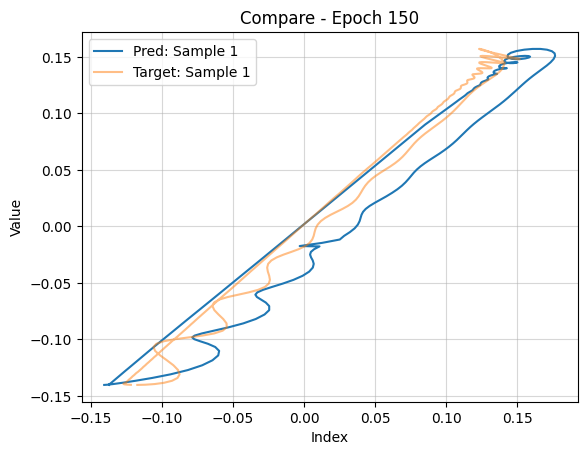

  H 無改善 wait_H=3/150
Epoch 151 | Learning Rate: 0.002000
---
alpha: 0.101
Epoch 151, loss_H: 0.000566, loss_Pcv: 0.011382
Epoch 151 | Train Loss: 0.001735 | Val Loss: 0.001655 | Time: 5.12s
(Best Epoch 147 | best H: 0.000573| best Pcv: 0.013570| val_loss : 0.001655)
✅ Save best H @ epoch 151
Epoch 152 | Learning Rate: 0.002000
---
alpha: 0.101
Epoch 152, loss_H: 0.000560, loss_Pcv: 0.011248
Epoch 152 | Train Loss: 0.001762 | Val Loss: 0.001643 | Time: 5.31s
(Best Epoch 151 | best H: 0.000566| best Pcv: 0.011382| val_loss : 0.001643)
✅ Save best H @ epoch 152
Epoch 153 | Learning Rate: 0.002000
---
alpha: 0.102
Epoch 153, loss_H: 0.000548, loss_Pcv: 0.011096
Epoch 153 | Train Loss: 0.001741 | Val Loss: 0.001624 | Time: 5.26s
(Best Epoch 152 | best H: 0.000560| best Pcv: 0.011248| val_loss : 0.001624)
✅ Save best H @ epoch 153
Epoch 154 | Learning Rate: 0.002000
---
alpha: 0.103
Epoch 154, loss_H: 0.000520, loss_Pcv: 0.013157
Epoch 154 | Train Loss: 0.001876 | Val Loss: 0.001818 | Time: 

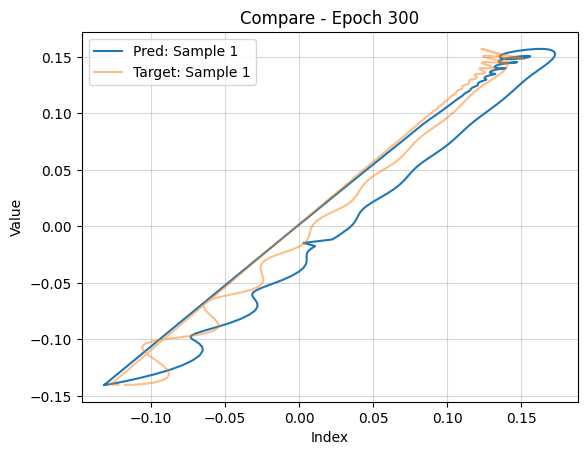

✅ Save best H @ epoch 300
Epoch 301 | Learning Rate: 0.001980
---
alpha: 0.201
Epoch 301, loss_H: 0.000290, loss_Pcv: 0.008895
Epoch 301 | Train Loss: 0.002188 | Val Loss: 0.002017 | Time: 5.04s
(Best Epoch 300 | best H: 0.000293| best Pcv: 0.008980| val_loss : 0.002017)
✅ Save best H @ epoch 301
Epoch 302 | Learning Rate: 0.001980
---
alpha: 0.201
Epoch 302, loss_H: 0.000307, loss_Pcv: 0.008581
Epoch 302 | Train Loss: 0.002324 | Val Loss: 0.001973 | Time: 5.04s
(Best Epoch 301 | best H: 0.000290| best Pcv: 0.008895| val_loss : 0.001973)
  H 無改善 wait_H=1/150
Epoch 303 | Learning Rate: 0.001980
---
alpha: 0.202
Epoch 303, loss_H: 0.000347, loss_Pcv: 0.010171
Epoch 303 | Train Loss: 0.002417 | Val Loss: 0.002332 | Time: 5.40s
(Best Epoch 301 | best H: 0.000290| best Pcv: 0.008895| val_loss : 0.002332)
  H 無改善 wait_H=2/150
Epoch 304 | Learning Rate: 0.001980
---
alpha: 0.203
Epoch 304, loss_H: 0.000366, loss_Pcv: 0.009870
Epoch 304 | Train Loss: 0.003285 | Val Loss: 0.002292 | Time: 5.38s

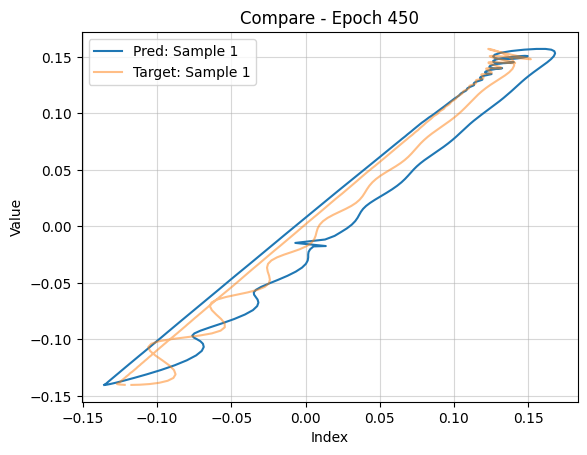

  H 無改善 wait_H=103/150
Epoch 451 | Learning Rate: 0.001960
---
alpha: 0.301
Epoch 451, loss_H: 0.000424, loss_Pcv: 0.008781
Epoch 451 | Train Loss: 0.005182 | Val Loss: 0.002937 | Time: 5.10s
(Best Epoch 347 | best H: 0.000285| best Pcv: 0.009625| val_loss : 0.002937)
  H 無改善 wait_H=104/150
Epoch 452 | Learning Rate: 0.001960
---
alpha: 0.301
Epoch 452, loss_H: 0.000528, loss_Pcv: 0.009697
Epoch 452 | Train Loss: 0.003276 | Val Loss: 0.003291 | Time: 5.08s
(Best Epoch 347 | best H: 0.000285| best Pcv: 0.009625| val_loss : 0.003291)
  H 無改善 wait_H=105/150
Epoch 453 | Learning Rate: 0.001960
---
alpha: 0.302
Epoch 453, loss_H: 0.000476, loss_Pcv: 0.008137
Epoch 453 | Train Loss: 0.003684 | Val Loss: 0.002790 | Time: 5.20s
(Best Epoch 347 | best H: 0.000285| best Pcv: 0.009625| val_loss : 0.002790)
  H 無改善 wait_H=106/150
Epoch 454 | Learning Rate: 0.001960
---
alpha: 0.303
Epoch 454, loss_H: 0.000477, loss_Pcv: 0.008529
Epoch 454 | Train Loss: 0.003235 | Val Loss: 0.002914 | Time: 5.26s
(

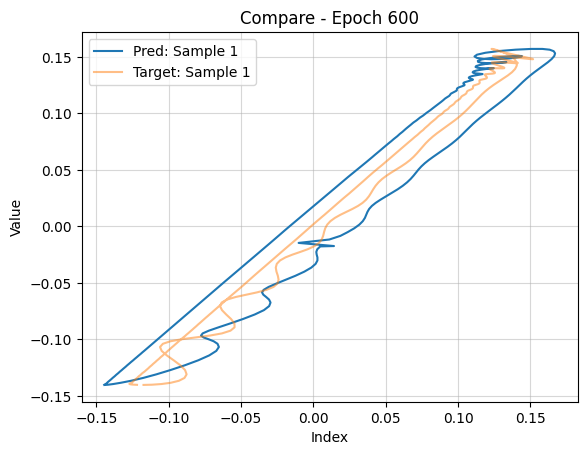

  Pcv 無改善 wait_Pcv=23/150
Epoch 601 | Learning Rate: 0.001941
---
alpha: 0.401
Epoch 601, loss_H: 0.000632, loss_Pcv: 0.009912
Epoch 601 | Train Loss: 0.004845 | Val Loss: 0.004350 | Time: 5.06s
(Best Epoch 577 | best H: 0.000481| best Pcv: 0.008044| val_loss : 0.004350)
  Pcv 無改善 wait_Pcv=24/150
Epoch 602 | Learning Rate: 0.001941
---
alpha: 0.401
Epoch 602, loss_H: 0.000570, loss_Pcv: 0.008688
Epoch 602 | Train Loss: 0.004737 | Val Loss: 0.003828 | Time: 5.17s
(Best Epoch 577 | best H: 0.000481| best Pcv: 0.008044| val_loss : 0.003828)
  Pcv 無改善 wait_Pcv=25/150
Epoch 603 | Learning Rate: 0.001941
---
alpha: 0.402
Epoch 603, loss_H: 0.000564, loss_Pcv: 0.008759
Epoch 603 | Train Loss: 0.003781 | Val Loss: 0.003858 | Time: 4.99s
(Best Epoch 577 | best H: 0.000481| best Pcv: 0.008044| val_loss : 0.003858)
  Pcv 無改善 wait_Pcv=26/150
Epoch 604 | Learning Rate: 0.001941
---
alpha: 0.403
Epoch 604, loss_H: 0.000573, loss_Pcv: 0.009550
Epoch 604 | Train Loss: 0.004754 | Val Loss: 0.004188 | T

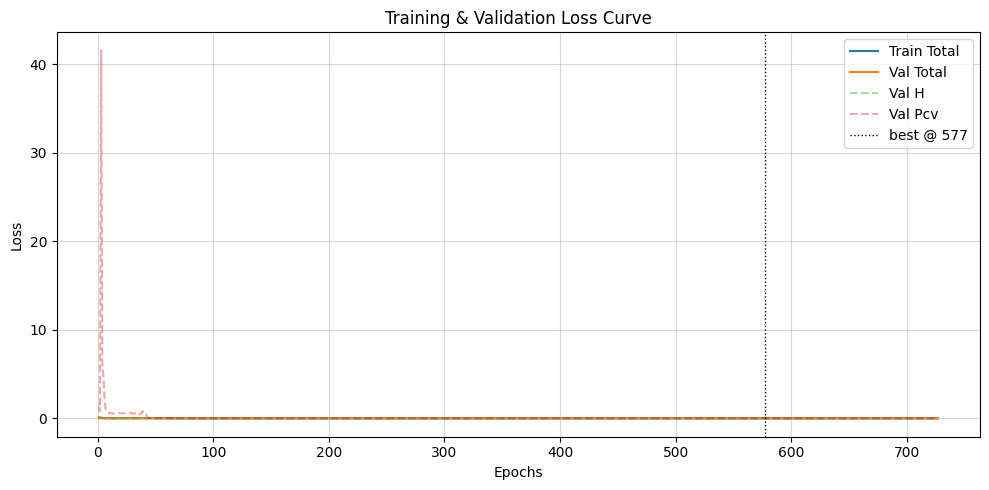

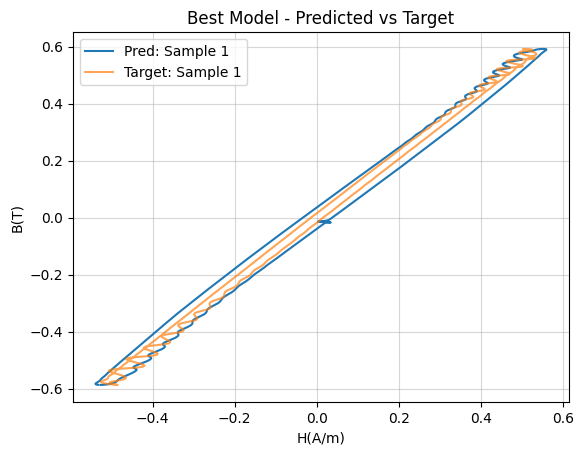

In [24]:
if __name__ == "__main__":
    main()